In [34]:
import numpy as np
from matplotlib import pyplot as plt

import M8195A as awg
awg_ip = "192.168.0.250"

from sigproc_kit import *

In [41]:
##################################################
##                 delme!                 ##
##################################################


period = 200e-9
width="20n"
leading_edge="1n"
trailing_edge="1n"
on_val=-500e-3
idle_val="0m"



# tag 2025
delay=0




awg.pulser(
    ip=awg_ip,
    trace=1,
    period=period,
    width="100n",
    leading_edge=leading_edge,
    trailing_edge=leading_edge,
    on_val=on_val,
    idle_val=idle_val,
    delay=10e-9+delay
)

awg.pulser(
    ip=awg_ip,
    trace=2,
    period=period,
    width="100n",
    leading_edge=leading_edge,
    trailing_edge=leading_edge,
    on_val=on_val,
    idle_val=idle_val,
    delay=10e-9
)

awg.pulser(
    ip=awg_ip,
    trace=3,
    period=period,
    width="30n",
    leading_edge=leading_edge,
    trailing_edge=leading_edge,
    on_val=on_val,
    idle_val=idle_val,
    delay=10e-9
)

target ip : 192.168.0.250
connect to device ...
*IDN?
Keysight Technologies,M8195A,DE57700132,4.0.0.0-1
success!
NOTE: overriding sample rate to match desired period!
attempting to set sample rate : 64640000000.000000 Hz
success!
preparing data for channel 1
delete trace 2, because wrong mem size / wrong period
sending data ...
set output voltage ...
Output 1 on ...
RUN!
close socket
target ip : 192.168.0.250
connect to device ...
*IDN?
Keysight Technologies,M8195A,DE57700132,4.0.0.0-1
success!
NOTE: overriding sample rate to match desired period!
attempting to set sample rate : 64640000000.000000 Hz
success!
preparing data for channel 2
sending data ...
set output voltage ...
Output 2 on ...
RUN!
close socket
target ip : 192.168.0.250
connect to device ...
*IDN?
Keysight Technologies,M8195A,DE57700132,4.0.0.0-1
success!
NOTE: overriding sample rate to match desired period!
attempting to set sample rate : 64640000000.000000 Hz
success!
preparing data for channel 3
sending data ...
set 

4000
4000
target ip : 192.168.0.250
connect to device ...
*IDN?
Keysight Technologies,M8195A,DE57700132,4.0.0.0-1
success!
NOTE: overriding sample rate to match desired period!
attempting to set sample rate : 64640000000.000000 Hz
success!
preparing data for channel 4
sending data ...
set output voltage ...
Output 4 on ...
RUN!
close socket


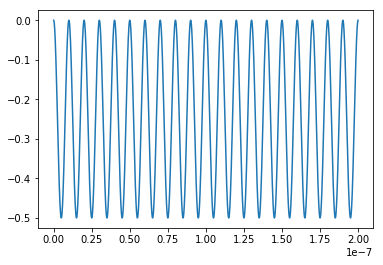

In [42]:
##################################################
##             make a 100 MHz clock             ##
##################################################



x = np.arange(0,period,50e-12)
y = 0.25*np.cos(2*np.pi*100e6*x)-0.25

print(len(x))
print(len(y))

plt.plot(x,y)

awg.send_data(x,y,
              trace=4,
              ip=awg_ip,
              period=period)

In [1]:
import serial
import time

# Set up the serial connection
ser = serial.Serial('/dev/ttyACM1', 115200)  # Adjust the baud rate if necessary
time.sleep(.1)  # Wait for the connection to establish


def ask(cmd,**kwargs):
    # function waits for an answer, since readline is blocking 
    ser.reset_input_buffer()
    ser.write(f"{cmd}\n".encode())  # Send the number followed by a newline
    #time.sleep(.001)  # Wait for a second before sending the next number
    line = ser.readline().decode()
    line = line.replace("\r","")
    line = line.replace("\n","")
    #print("readback: ",end="")
    return line




def r_fpga_reg(n):
    cmd="01{:02x}{:04x}".format(n,0);
    ans = ask(cmd)
    return int(ans[4:],16)

def w_fpga_reg(n,val):
    cmd="02{:02x}{:04x}".format(n,val);
    return ask(cmd)

def w_fpga_reg_bit(n,b,state):
    cur_val = r_fpga_reg(n)
    new_val = (cur_val & ~(1<<b)) | (state*(1<<b))
    w_fpga_reg(n, new_val)

In [29]:
print(ask("0102"))

r_fpga_reg(0)

01020B3B


65535

In [ ]:
# testing the CORDICAtan2

a = 10
b = 3

w_fpga_reg(0,a)
w_fpga_reg(1,b)

c = r_fpga_reg(2)

c

In [47]:
def to_twos_complement(value):
    # Ensure the value is within the range of a signed 12-bit integer
    if value < -2048 or value > 2047:
        raise ValueError("Value must be between -2048 and 2047 for 12-bit representation.")
    
    # Calculate two's complement
    if value < 0:
        value = (1 << 12) + value  # Add 2^12 to the negative value
    return value

# Example usage
number = -5
twos_complement = to_twos_complement(number)
print(f"Two's complement of {number} in 12 bits is: {twos_complement:012b}")


def from_twos_complement(twos_comp):
    # Ensure the value is within the range of a 12-bit integer
    if twos_comp < 0 or twos_comp >= (1 << 12):
        raise ValueError("Value must be a 12-bit two's complement integer (0 to 4095).")
    
    # Check if the number is negative
    if twos_comp >= (1 << 11):  # If the MSB is 1
        return twos_comp - (1 << 12)  # Convert to negative
    return twos_comp  # Return the positive value

# Example usage
twos_comp_value = 0b111110101011  # Example two's complement value for -5
signed_integer = from_twos_complement(twos_comp_value)
print(f"Signed integer from two's complement {twos_comp_value:012b} is: {signed_integer}")



Two's complement of -5 in 12 bits is: 111111111011
Signed integer from two's complement 111110101011 is: -85


3996

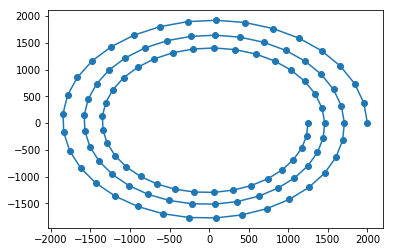

In [42]:
t = np.linspace(0, 3*2*np.pi, 100)
tau = 40
x = np.cos(t) * np.exp(-t/tau)
y = np.sin(t) * np.exp(-t/tau)

x = x * 2000
y = y * 2000

plt.scatter(x,y)
plt.plot(x,y)

In [48]:
c = np.zeros(len(x))

for i in range(len(x)):
    w_fpga_reg(0,to_twos_complement(int(x[i])))
    w_fpga_reg(1,to_twos_complement(int(y[i])))
    c[i] = from_twos_complement(r_fpga_reg(2))
    

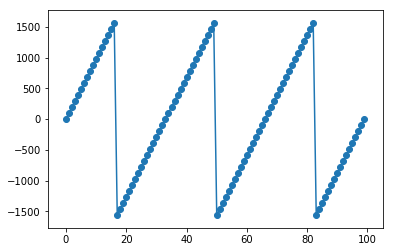

In [52]:
plt.plot(c)
plt.scatter(list(range(len(c))),c)

In [50]:
np.max(np.abs(c))

1559.0